In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Dropout

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/users/user/8k',
    label_mode='categorical',
    batch_size=32,
    image_size=(128,128),
    interpolation='area',
    shuffle=True,
    seed=123
)

import numpy as np
def process(x, y):
    x/=128.0
    x-=1
    return x
normalized_ds = train_dataset.map(process)

AUTOTUNE = tf.data.AUTOTUNE

dataset = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE).shuffle(1000)

Found 8091 files belonging to 1 classes.


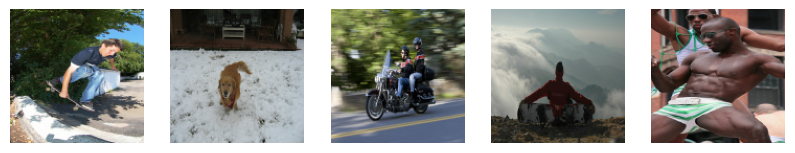

In [5]:
def imshow():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images in dataset.take(1):
        for i in range(n):
            img = images[i]
            
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow((img+1)/2, cmap='gist_gray')
            plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [6]:
inputs = Input((128,128,3))
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
res1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(res1)
res2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(res2)
x = Dropout(0.1)(x)
res3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(res3)
x = Dropout(0.1)(x)
res4 = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(res4)
x = Dropout(0.1)(x)
res5 = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(256, 3, activation = 'relu', padding = 'same', strides = 2)(res5)
x = Dropout(0.1)(x)
res6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(x)

x = Conv2D(256, 3, activation = 'relu', padding = 'same')(res6)
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Concatenate()([x, res5])
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Concatenate()([x, res4])
x = Conv2DTranspose(128, 3, activation = 'relu', padding = 'same')(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Concatenate()([x, res3])
x = Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Concatenate()([x, res2])
x = Conv2DTranspose(32, 3, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(32, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Concatenate()([x, res1])

x = Conv2DTranspose(32, 3, activation = 'relu', padding = 'same')(x)
x = Concatenate()([x, inputs])
x = Conv2DTranspose(32, 3, activation = 'relu', padding = 'same')(x)

x = Conv2DTranspose(3, 3, activation = 'linear', padding = 'same')(x)

outputs = x

unet = keras.Model(inputs, outputs)

In [34]:
class Model(tf.keras.Model):
    def __init__(self, nn_unet):
        super(Model, self).__init__()
        self.nn_unet = nn_unet
        
        self.unet_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
        
    def apply_noise(self, x, t):
        
        
        noise = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2],1))*5
        for tau in range(2,16):
            noise2 = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1]//tau,tf.shape(x)[2]//tau,1))
            noise2 = tf.image.resize(noise2, (tf.shape(x)[1], tf.shape(x)[2]))
            noise+=noise2
        noise = tf.concat([noise,noise,noise], axis = 3)
        
        color_noise = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2],3))*5
        for tau in range(2,16):
            color_noise2 = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1]//tau,tf.shape(x)[2]//tau,3))
            color_noise2 = tf.image.resize(color_noise2, (tf.shape(x)[1], tf.shape(x)[2]))
            color_noise+=color_noise2
        noise = noise + color_noise
        noise/=8
        b = 1. - t
        return x*b + noise*t, noise
    
    @tf.function
    def training_step(self, x):
        
        x_n , n = self.apply_noise(x, tf.random.uniform([],0.1,0.2))
        
        with tf.GradientTape() as tape_unet:
            
            predicted_noise = self.nn_unet(x_n, training=True)

            loss = (
                tf.reduce_mean((predicted_noise - n) ** 2)
            )
            

        # Backpropagation.
        grads_e = tape_unet.gradient(loss, self.nn_unet.trainable_variables)
        self.unet_optimizer.apply_gradients(zip(grads_e, self.nn_unet.trainable_variables))

        return loss

In [35]:
model = Model(unet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


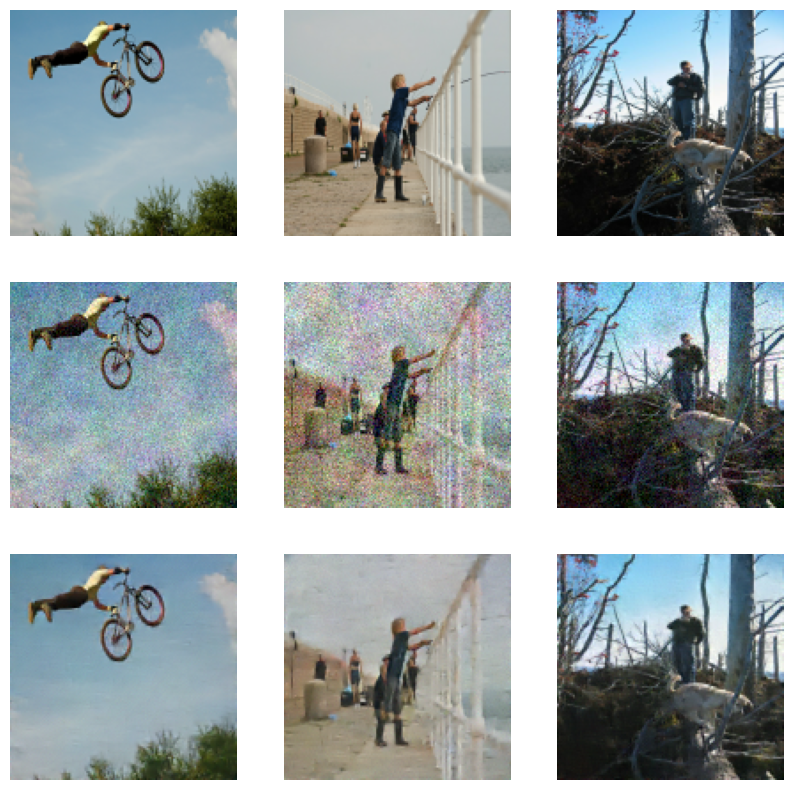

In [41]:
def testing():
    
    n = 3
    plt.figure(figsize=(10, 10))
    for images in dataset.take(5):
        for i in range(n):
            
            #посмотрим на картинки
            ax = plt.subplot(3, n, i + 1)
            im = images[i].numpy()
            plt.imshow((im+1)/2)
            #plt.title(str(model.nn_disc(tf.expand_dims(images[i], axis = 0)).numpy()[0][0]))
            plt.axis('off')
            ax.get_xaxis().set_visible(False)
            
            #посмотрим шумные картинки
            nl = tf.random.uniform([],0.1,0.2)
            
            ax = plt.subplot(3, n, i + 1+ n)
            noisy, noise = model.apply_noise(tf.expand_dims(images[i], axis = 0),nl)
            noisy = tf.squeeze(noisy, axis = 0)
            noise = tf.squeeze(noise, axis = 0)
            noisy_n = noisy.numpy()
            noisy_n = np.clip(noisy_n, -1, 1)
            im = (noisy_n+1)/2
            plt.imshow(im)
            #plt.title(str(model.nn_disc(tf.expand_dims(images[i], axis = 0)).numpy()[0][0]))
            plt.axis('off')
            ax.get_xaxis().set_visible(False)
            
            
            #используем нейросеть чтобы найти шум
            ax = plt.subplot(3, n, i + 1+ n*2)
            
            noise = tf.squeeze(model.nn_unet(tf.expand_dims(noisy, axis = 0)), axis = 0)
            #plt.title(str(model.nn_disc(tf.expand_dims(generated, axis = 0)).numpy()[0][0]))
            c = ((noisy.numpy() - noise.numpy()*nl)+1)/2
            
            plt.imshow(c)
            plt.axis('off')
            ax.get_xaxis().set_visible(False)
            
            
   
            
    plt.show()
testing()

8


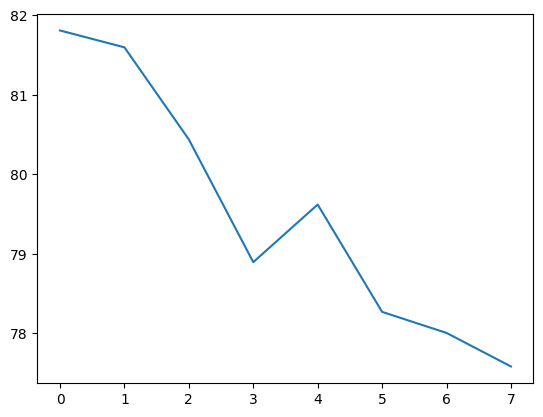

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


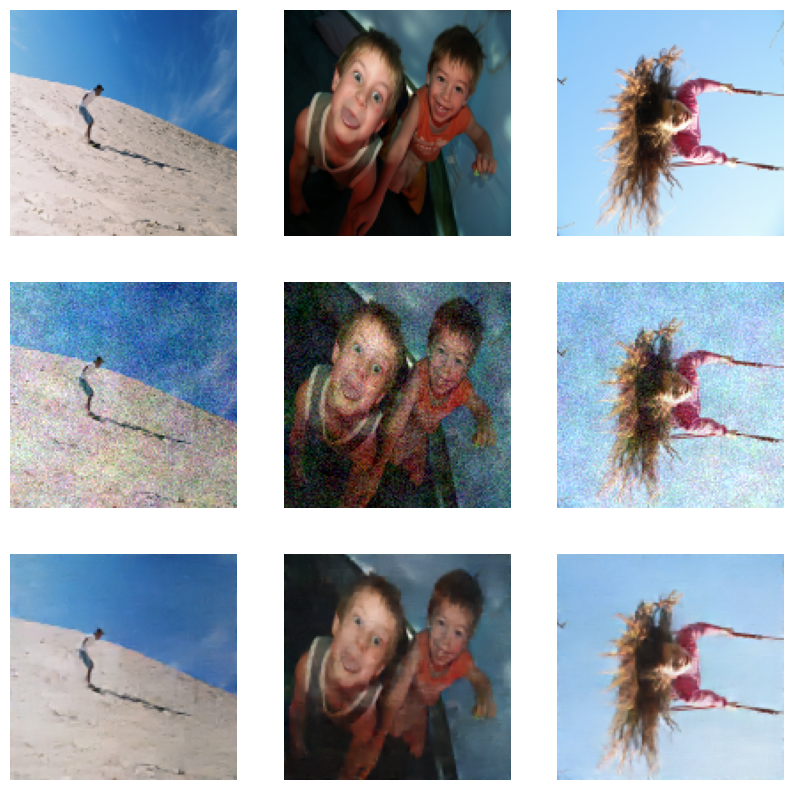

KeyboardInterrupt: 

In [37]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 50
for epoch in range(1, epochs + 1):
    loss = 0
    for step, x in enumerate(dataset):
        loss+=model.training_step(x)
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()
    testing()

In [12]:
model.nn_unet.load_weights('denoising_unet.h5')

In [27]:
def denoise_image(image):  #input: numpy image x, y , 3,   0...256
    w = image.shape[1]
    h = image.shape[0]
    num_w_cycles = w//128
    num_h_cycles = h//128
    for h_pos in range(num_h_cycles*2-1):
        frames = np.zeros((num_w_cycles*2, 128, 128, 3), dtype=np.int16)
        for w_pos in range(num_w_cycles*2-1):
            frames[w_pos] = image[h_pos*64:h_pos*64+128, w_pos*64:w_pos*64+128, :]
        tensor = tf.cast(frames, tf.float32)/128 -1
        noise_tensor = model.nn_unet(tensor)
        clear = tensor-noise_tensor*0.1
        clear = clear.numpy()
        for w_pos in range(num_w_cycles*2-1):
            fragment = clear[w_pos]
            fragment = fragment[32:96, 32:96,:]
            if w_pos == 0:
                row = fragment
            else:
                row = np.concatenate((row, fragment), axis = 1)    
        
        if h_pos == 0:
            out_frame = row
        else:
            out_frame = np.concatenate((out_frame, row), axis = 0)
    return (out_frame+1)/2

In [44]:
import cv2
cap = cv2.VideoCapture("noisy.mp4")
#cap.set(cv2.CAP_PROP_POS_FRAMES, 100)

result = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'MJPG'),20, (1600, 800))
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = tf.image.resize(frame, (1200, 1200), method = 'area').numpy()
    
    a = denoise_image(frame)
    a = denoise_image(a*255)
   
    a = cv2.resize(a, (800,800)).copy()
    frame = cv2.resize(frame, (800,800))
    b = np.concatenate((frame/255, a), axis = 1)
    
    b*= 255
    b = np.clip(b, 0, 255)
    ub = b.astype(np.uint8)
    cv2.imshow('frame', ub)
    result.write(ub)
    #cv2.imshow('frame', ff)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
result.release()